# 配置环境

In [ ]:
cd /content/drive/MyDrive/mask rcnn_test

In [ ]:
!pip uninstall tensorflow --yes

In [ ]:
!pip uninstall PyYAML --yes

In [ ]:
!pip install -r requirements.txt

In [ ]:
!pip list

In [ ]:
cd /content/drive/MyDrive/mask rcnn_test

# 导入相关包

In [1]:
# -*- coding: utf-8 -*-

import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
from mrcnn.config import Config
#import utils
from mrcnn import model as modellib,utils
from mrcnn import visualize
import yaml
from mrcnn.model import log
from PIL import Image
"""
加入自己类别名称
更改类别个数
"""

# os.environ["CUDA_VISIBLE_DEVICES"] = "0"
# Root directory of the project
ROOT_DIR = os.getcwd()

#ROOT_DIR = os.path.abspath("../")
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

iter_num=0

%matplotlib inline 
# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "saved_weight/mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)


Using TensorFlow backend.


# Configuration

In [3]:
class CategoryConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "shapes"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 2  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 320
    IMAGE_MAX_DIM = 384

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8 * 6, 16 * 6, 32 * 6, 64 * 6, 128 * 6)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 100

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 50

# Dataset

In [4]:
class CategoryDataset(utils.Dataset):
    # 得到该图中有多少个实例（物体）
    def get_obj_index(self, image):
        n = np.max(image)
        return n

    # 解析labelme中得到的yaml文件，从而得到mask每一层对应的实例标签
    def from_yaml_get_class(self, image_id):
        info = self.image_info[image_id]
        with open(info['yaml_path']) as f:
            temp = yaml.load(f.read(), Loader=yaml.FullLoader)
            labels = temp['label_names']
            del labels[0]
        return labels

    # 重新写draw_mask
    def draw_mask(self, num_obj, mask, image, image_id):
        info = self.image_info[image_id]
        for index in range(num_obj):
            for i in range(np.shape(mask)[1]):
                for j in range(np.shape(mask)[0]):
                    at_pixel = image.getpixel((i, j))
                    if at_pixel == index + 1:
                        mask[j, i, index] =1
        return mask

    # 重新写load_shapes，里面包含自己的自己的类别
    # self.add_class("shapes", 1, "category1") 
    #并在self.image_info信息中添加了path、mask_path 、yaml_path
    def load_shapes(self, count, img_floder, mask_floder, imglist, yaml_floder):
        
        # TODO=======================需修改========================
        self.add_class("shapes", 1, "category1") 
        self.add_class("shapes", 2, "category2") 
        # TODO=========================需修改======================
        
        for i in range(count):
            img = imglist[i]
            if img.endswith(".jpg"):
                img_name = img.split(".")[0]
                img_path = img_floder + img
                mask_path = mask_floder + img_name + ".png"
                yaml_path = yaml_floder + img_name + ".yaml"
                self.add_image("shapes", image_id=i, path=img_path, mask_path=mask_path,yaml_path=yaml_path)
    
    # 重写load_mask
    def load_mask(self, image_id):
        info = self.image_info[image_id]
        img = Image.open(info['mask_path'])
        num_obj = self.get_obj_index(img)
        mask = np.zeros([np.shape(img)[0], np.shape(img)[1], num_obj], dtype=np.uint8)
        mask = self.draw_mask(num_obj, mask, img, image_id)
        labels=[]
        labels=self.from_yaml_get_class(image_id)
        labels_form=[]

        # TODO=========================需修改======================
        for i in range(len(labels)):
            if labels[i].find("category1")!=-1:
                labels_form.append("category1")
            elif labels[i].find("category2")!=-1:
                labels_form.append("category2")
        # TODo=========================需修改======================
        
        class_ids = np.array([self.class_names.index(s) for s in labels_form])
        return mask, class_ids.astype(np.int32)

# Notebook preference

In [5]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.

    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size * cols, size * rows))
    return ax


# 路径

In [6]:
#基础设置
dataset_root_path="dataset/category_dataset/"
img_floder = dataset_root_path + "imgs/"
mask_floder = dataset_root_path + "mask/"
yaml_floder = dataset_root_path + "yaml/"
imglist = os.listdir(img_floder)
count = len(imglist)
np.random.seed(10101)
np.random.shuffle(imglist)
train_imglist = imglist[:int(count*0.9)]
val_imglist = imglist[int(count*0.9):]


In [7]:
# 加载配置文件
config = CategoryConfig()
# 计算训练集和验证集长度
config.STEPS_PER_EPOCH = len(train_imglist)//config.IMAGES_PER_GPU
config.VALIDATION_STEPS = len(val_imglist)//config.IMAGES_PER_GPU
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.75
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  384
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  320
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [384 384   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES

# 准备数据集

In [8]:
# 训练数据集准备
dataset_train = CategoryDataset()
dataset_train.load_shapes(len(train_imglist), img_floder, mask_floder, train_imglist, yaml_floder)
dataset_train.prepare()
print("dataset_train-->",dataset_train._image_ids)
print("Train Image Count: {}".format(len(dataset_train.image_ids)))
print("Train Class Count: {}".format(dataset_train.num_classes))
for i, info in enumerate(dataset_train.class_info):
    print("{:3}. {:50}".format(i, info['name']))
# 验证数据集准备
dataset_val = CategoryDataset()
dataset_val.load_shapes(len(val_imglist), img_floder, mask_floder, val_imglist, yaml_floder)
dataset_val.prepare()
print("dataset_val-->",dataset_val._image_ids)

print("Validation Image Count: {}".format(len(dataset_val.image_ids)))
print("Validation Class Count: {}".format(dataset_val.num_classes))
for i, info in enumerate(dataset_val.class_info):
    print("{:3}. {:50}".format(i, info['name']))

dataset_train--> [0 1 2 3 4 5 6 7]
Train Image Count: 8
Train Class Count: 3
  0. BG                                                
  1. category1                                         
  2. category2                                         
dataset_val--> [0]
Validation Image Count: 1
Validation Class Count: 3
  0. BG                                                
  1. category1                                         
  2. category2                                         


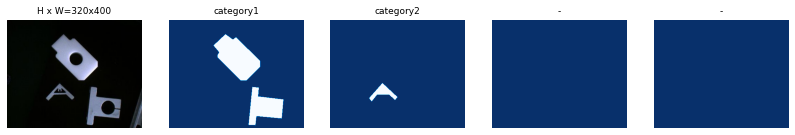

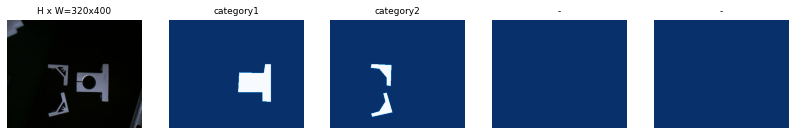

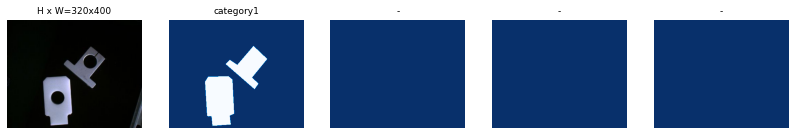

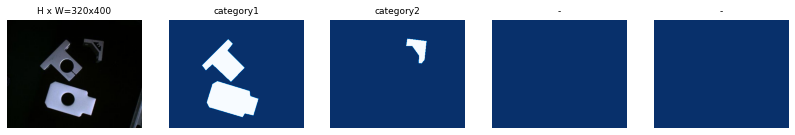

In [9]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

# Create Model

In [10]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


In [11]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last()[1], by_name=True)


# 训练

In [12]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE,
            epochs=2,
            layers='heads')




Starting at epoch 0. LR=0.001

Checkpoint Path: e:\My Projects\mask rcnn_test\logs\shapes20210910T1722\mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mr

D:\Anaconda3\envs\mask_r_cnn\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
D:\Anaconda3\envs\mask_r_cnn\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
D:\Anaconda3\envs\mask_r_cnn\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "






Epoch 1/2
5/8 [=================>............] - ETA: 48s - loss: 4.1152 - rpn_class_loss: 0.1559 - rpn_bbox_loss: 0.9618 - mrcnn_class_loss: 1.4212 - mrcnn_bbox_loss: 0.9133 - mrcnn_mask_loss: 0.6631 

KeyboardInterrupt: 

In [ ]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE / 10,
            epochs=5,
            layers="all")

保存模型权重

In [ ]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
model_save_path = os.path.join(MODEL_DIR, "saved_weight/mask_rcnn_category.h5")
model.keras_model.save_weights(model_save_path)

# Detection

In [ ]:
class InferenceConfig(CategoryConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = 'logs/mask_rcnn_shapes.h5'

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

In [ ]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

In [ ]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

# Evaluation

In [ ]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))